## Look Elsewhere Effect in 2-d

Kyle Cranmer, Nov 19, 2015

Based on
*Estimating the significance of a signal in a multi-dimensional search* by  Ofer Vitells and Eilam Gross http://arxiv.org/pdf/1105.4355v1.pdf

This is for the special case of a likelihood function of the form 
$L(\mu, \nu_1, \nu_2)$ where $\mu$ is a single parameter of interest and
$\nu_1,\nu_2$ are two nuisance parameters that are not identified under the null.
For example, $\mu$ is the signal strength of a new particle and $\nu_1,\nu_2$ are the
unknown mass and width of the new particle. Under the null hypothesis, those parameters 
don't mean anything... aka they "are not identified under the null" in the statistics jargon.
This introduces a 2-d look elsewhere effect.

The LEE correction in this case is based on 

\begin{equation}
E[ \phi(A_u) ] = P(\chi^2_1 > u) + e^{-u/2} (N_1 + \sqrt{u} N_2) \,
\end{equation}
where 
   * $A_u$ is the 'excursion set above level $u$ (eg. the set of parameter points in $(\nu_1,\nu_2)$ that have a -2 log-likelihood ratio greater than $u$ )
   * $\phi(A_u)$ is the Euler characteristic of the excursion set
   * $E[ \phi(A_u) ]$ is the expectation of the Euler characteristic of those excursion sets under the null
   * $P(\chi^2_1 > u)$ is the standard chi-square probability 
   * and $N_1$ and $N_2$ are two coefficients that characterize the chi-square random field.
   
### structure of the notebook

The notebook is broken into two parts.
  * calculation of $N_1$ and $N_2$ based on $E[ \phi(A_u) ]$ at two different levels $u_1$ and $u_2$
  * calculation of LEE-corrected 'global p-value' given $N_1,N_2$
  * some code to calculate $\phi(A_u)$ using convolutional filters
  * Normal usage based on reading a ROOT file with several likleihood scans


In [1]:
%pylab inline --no-import-all
from scipy.optimize import fsolve
from scipy.stats import chi2
from numpy import exp, sqrt
from scipy.ndimage.morphology import *
from scipy.ndimage import *
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


In [2]:
import ROOT

Welcome to ROOTaaS 6.05/03


## Part 1: Calculate $N_1$ and $N_2$

In [3]:
def expectedEuler(u, n1, n2):
    return chi2.cdf(u, 1) + np.exp(-u/2)*(n1+n2*np.sqrt(u))

In [4]:
def equations(p,exp_phi_1, exp_phi_2,u1, u2):
    n1,n2 = p
    return (exp_phi_1-expectedEuler(u1,n1,n2), exp_phi_2-expectedEuler(u2,n1,n2))

Usage: calculate n1,n2 based on expected value of Euler characteristic (calculated from toy Monte Carlo) at two different levels u1, u2. For example: 
   * $u_1=0$ with $E[ \phi(A_{u=u_1})]=33.5 $ 
   * $u_2=1$ with $E[ \phi(A_{u=u_2})]=94.6 $

would lead to a call like this

```python
    n1, n2 = fsolve(equations, (1,1), args=(33.5, 94.6, 0., 1.))
```


### Part 1b: Given $N_1$ and $N_2$ calculate global p-value for given -2logL

In [5]:
def global_pvalue(u,n1,n2):
    return expectedEuler(u,n1,n2)-1.

In [6]:
def do_LEE_correction(max_local_sig, u1, u2, exp_phi_1, exp_phi_2):
    n1, n2 = fsolve(equations, (1,1), args=(exp_phi_1, exp_phi_2, u1,u2))
    this_global_p = global_pvalue(max_local_significance**2, n1, n2)
    print ' n1, n2 =', n1, n2
    print ' local p_value = %f,  local significance = %f' %(norm.cdf(-max_local_significance), max_local_significance)
    print 'global p_value = %f, global significance = %f' %(this_global_p, -norm.ppf(this_global_p))

## Part 2: Calculate Euler characteristic

In [7]:
def calculateEulerCharacteristic(a):
    face_filter=np.zeros((2,2))+1
    right_edge_filter = np.array([[1,1]])
    bottom_edge_filter = right_edge_filter.T
    
    n_faces = np.sum(convolve(a,face_filter,mode='constant')>3)
    n_edges = np.sum(convolve(a,right_edge_filter,mode='constant')>1)
    n_edges += np.sum(convolve(a,bottom_edge_filter,mode='constant')>1)
    n_vertices = np.sum(a>0)
    
    EulerCharacteristic = n_vertices-n_edges+n_faces
    print '%d-%d+%d=%d' %(n_vertices,n_edges,n_faces,EulerCharacteristic) 
    
    return n_vertices-n_edges+n_faces   

## Tests

### Test numerical solution to $N_1, N_2$  from the example in the paper

In [8]:
# An example from the paper
n1, n2 = fsolve(equations, (1,1), args=(33.5, 94.6, 0., 1.))

print n1, n2

print equations((n1,n2),33.5, 94.6, 0., 1.)
#small difference wrt the paper, where n2 = 123

33.5 121.343467521
(0.0, -1.4210854715202004e-14)


[]

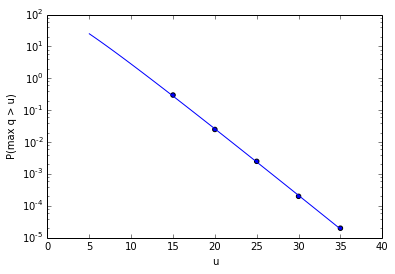

In [9]:
# reproduce Fig 5 from paper (the markers are read by eye)
u = np.linspace(5,35,100)
global_p = global_pvalue(u,n1,n2)
plt.plot(u, global_p)
plt.scatter(35,2.E-5) #from Fig5
plt.scatter(30,2.E-4) #from Fig5
plt.scatter(25,2.5E-3) #from Fig5
plt.scatter(20,2.5E-2) #from Fig5
plt.scatter(15,.3) #from Fig5
plt.xlabel('u')
plt.ylabel('P(max q > u)')
plt.semilogy()

### Check Euler characteristic from Fig 3 example in the paper

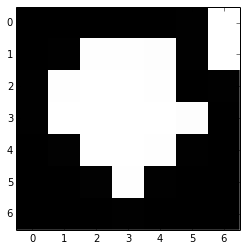

In [10]:
#create Fig 3 of http://arxiv.org/pdf/1105.4355v1.pdf
a = np.zeros((7,7))
a[1,2]=a[1,3]=a[2,1]=a[2,2]=a[2,3]=a[2,4]=1
a[3,1]=a[3,2]=a[3,3]=a[3,4]=a[3,5]=1
a[4,1]=a[4,2]=a[4,3]=a[4,4]=1
a[5,3]=1
a[6,0]=a[6,1]=1
a=a.T
plt.imshow(a,cmap='gray',interpolation='none')

In [11]:
#should be 2
calculateEulerCharacteristic(a) 

18-23+7=2


2

### Try a big matrix

In [12]:
#Fully filled, should be 1
randMatrix = np.zeros((100,100))+1
calculateEulerCharacteristic(randMatrix)

10000-19800+9801=1


1

9900-19501+9603=2


2

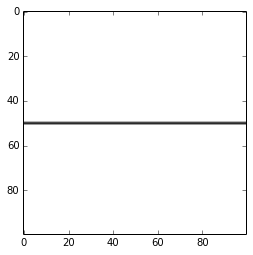

In [13]:
# split in half vertically, should be 2
randMatrix[50,:]=0
plt.imshow(randMatrix,cmap='gray')
calculateEulerCharacteristic(randMatrix)

9702-18911+9215=6


6

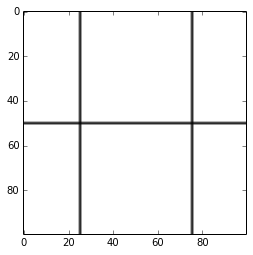

In [14]:
#split in half horizontally twice, should be 6
randMatrix[:,25]=0
randMatrix[:,75]=0
plt.imshow(randMatrix,cmap='gray')
calculateEulerCharacteristic(randMatrix)

9687-18873+9191=5


5

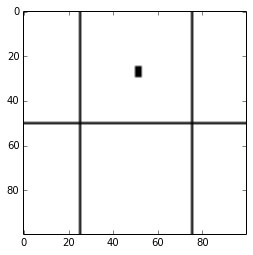

In [15]:
#remove a hole from middle of one, should be 5
randMatrix[25:30,50:53]=0
plt.imshow(randMatrix,cmap='gray')
calculateEulerCharacteristic(randMatrix)

## Calculate global p-value based on maximum local significance and several toy likelihood scans

In [16]:
# Specify the necessary info
max_local_significance = 4. 
root_file_name = 'test_hists.root'
num_toy_scans = 25
names_of_toy_likleihood_scans = [('scan_toy_%d' %(i)) for i in range(11,num_toy_scans)]

In [17]:
# choose u1, u2 thresholds for doing the scan.
# these are arbitrary 
# if tehre are enough toys the choice shouldn't matter, but 
# we may want to do some tests with other choices
this_u1, this_u2 = 0.1, 0.9

In [18]:
# for testing, comment this out for normal use
#names_of_toy_likleihood_scans = [('scan_toy%d_sub' %(i)) for i in [0,0,0,0]]

In [19]:
def convert_hist_to_numpy(hist):
    ''' a little helper script'''
    temp = np.zeros((hist.GetNbinsX(), hist.GetNbinsY()))
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            temp[i,j] = hist.GetBinContent(i+1, j+1)
    return temp

In [20]:
# Read in histograms, convert them to numpy arrays
inFile = ROOT.TFile(root_file_name, 'READ')
likelihoodScans = []
for histName in names_of_toy_likleihood_scans:
    inHist = inFile.Get(histName)
    temp = convert_hist_to_numpy(inHist)
    likelihoodScans.append(temp)   

In [43]:
def getEulerCharacteristics(listOfScans, u1=0.1, u2=0.9):
    '''loop through the likleihood scans and calculate expectation
    of Euler characteristic for excursion sets above levels u1, u2'''
    plt.figure(figsize=(9,len(listOfScans)*3))
    phis = np.zeros((len(listOfScans),2))
    for scan_no, scan in enumerate(listOfScans):
        plt.subplot(len(listOfScans),3,3*scan_no+1)
        aspect = 1.*scan.shape[0]/scan.shape[1]
        plt.imshow(scan.T, cmap='gray', aspect=aspect)

        #get excursion sets above those two levels
        exc1 = (scan>u1) + 0. #add 0. to convert from bool to double
        exc2 = (scan>u2) + 0.
        print '\nu1,u2 = ', u1, u2
                    
        plt.subplot(len(listOfScans),3,3*scan_no+2)
        plt.imshow(exc1.T, cmap='gray', aspect=aspect)
        plt.subplot(len(listOfScans),3,3*scan_no+3)
        plt.imshow(exc2.T, cmap='gray', aspect=aspect)

        phi1 = calculateEulerCharacteristic(exc1)
        phi2 = calculateEulerCharacteristic(exc2)
        print 'phi1, phi2 = ', phi1, phi2
        phis[scan_no] = [phi1, phi2]

    plt.savefig('islands.png')
    print 'Exp phi_0=%f, phi_2=%f' %(mean(phis[:,0]), mean(phis[:,1]))
    return mean(phis[:,0]), mean(phis[:,1])
                    


u1,u2 =  0.1 0.9
1427-2632+1210=5
446-769+329=6
phi1, phi2 =  5 6

u1,u2 =  0.1 0.9
979-1783+808=4
214-347+139=6
phi1, phi2 =  4 6

u1,u2 =  0.1 0.9
1412-2639+1231=4
504-901+400=3
phi1, phi2 =  4 3

u1,u2 =  0.1 0.9
943-1746+806=3
177-298+125=4
phi1, phi2 =  3 4

u1,u2 =  0.1 0.9
1459-2679+1227=7
638-1131+499=6
phi1, phi2 =  7 6

u1,u2 =  0.1 0.9
1363-2502+1145=6
600-1057+463=6
phi1, phi2 =  6 6

u1,u2 =  0.1 0.9
1337-2497+1163=3
594-1066+476=4
phi1, phi2 =  3 4

u1,u2 =  0.1 0.9
1413-2585+1179=7
538-948+416=6
phi1, phi2 =  7 6

u1,u2 =  0.1 0.9
1240-2325+1088=3
603-1107+507=3
phi1, phi2 =  3 3

u1,u2 =  0.1 0.9
1363-2553+1193=3
586-1040+459=5
phi1, phi2 =  3 5

u1,u2 =  0.1 0.9
958-1733+782=7
204-350+150=4
phi1, phi2 =  7 4

u1,u2 =  0.1 0.9
1373-2586+1216=3
646-1165+522=3
phi1, phi2 =  3 3

u1,u2 =  0.1 0.9
1166-2162+1001=5
584-1055+475=4
phi1, phi2 =  5 4

u1,u2 =  0.1 0.9
1773-3339+1570=4
892-1617+731=6
phi1, phi2 =  4 6
Exp phi_0=4.571429, phi_2=4.714286


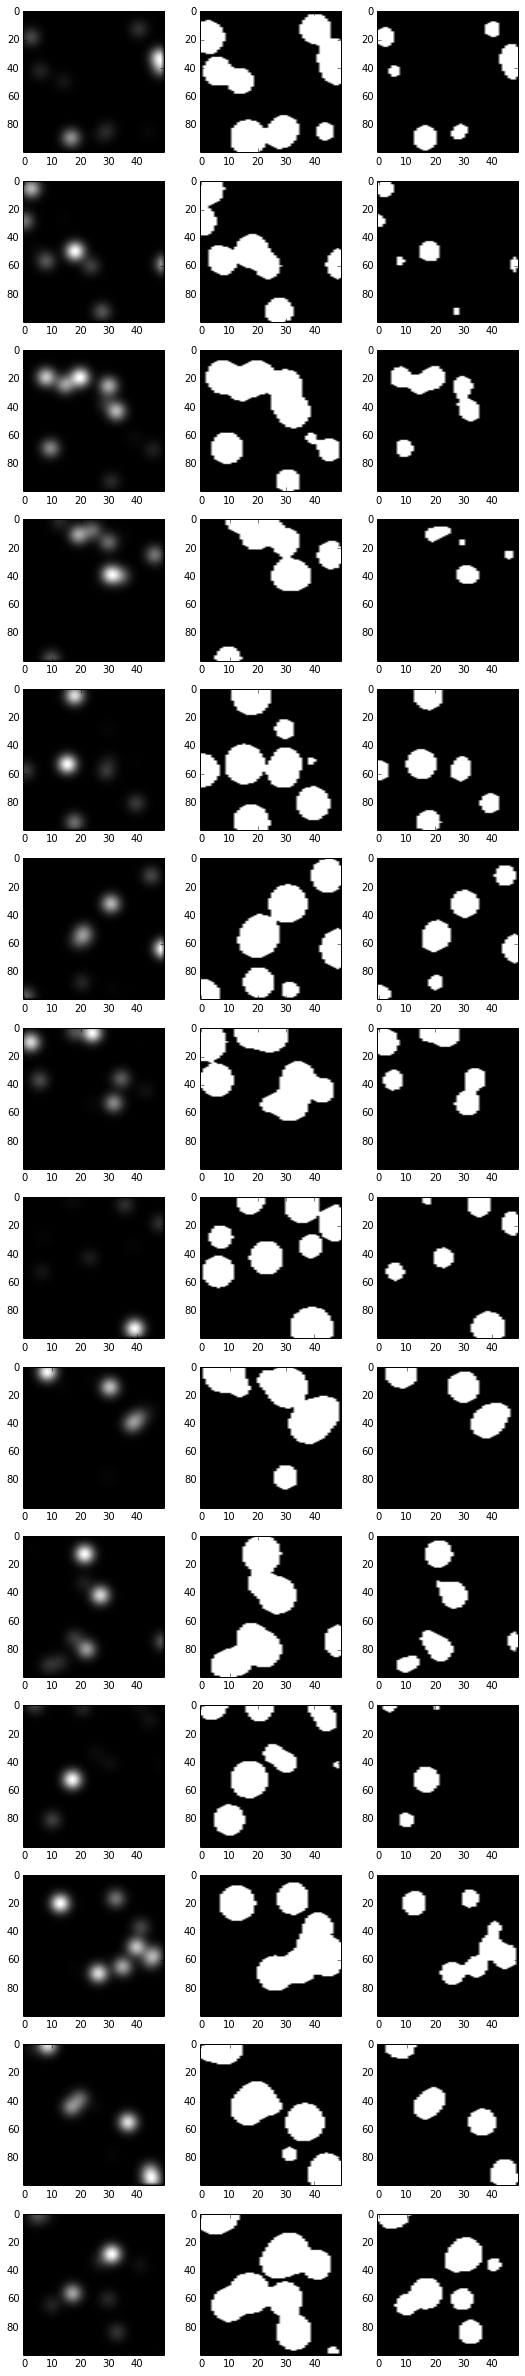

In [44]:
expphi1, expphi2 = getEulerCharacteristics(likelihoodScans, u1=this_u1, u2=this_u2)

In [ ]:
do_LEE_correction(max_local_significance, this_u1, this_u2, expphi1, expphi2)

In [ ]:
max_local_significance=4.96
do_LEE_correction(max_local_significance, this_u1, this_u2, expphi1, expphi2)

In [ ]:
max_local_significance=3.87
do_LEE_correction(3.87, this_u1, this_u2, expphi1, expphi2)

## Create some test histograms

In [39]:
def createTestScan(nx=50,ny=100, n_components=10):
    xarray = np.arange(-1,1,1./nx)
    yarray = np.arange(-1,1,1./ny)
    xx,yy = np.meshgrid(xarray,yarray)
    xmeans = 2*np.random.rand(n_components)-1.
    ymeans = 2*np.random.rand(n_components)-1.
    amps = np.random.chisquare(1,n_components)
    zz = xx*0
    for i, amp in enumerate(amps):
        xmean, ymean = xmeans[i], ymeans[i]
        zz += amp*np.exp(-((xx-xmean)**2+(yy-ymean)**2)/(2.*0.3**4))
    return xx, yy, zz

def createTestHistograms(nHists=25, nx=50,ny=100, n_components=10, fname='test_hists.root'):
    f_ = ROOT.TFile(fname,'RECREATE')
    for i in range(nHists):
        xx, yy, zz = createTestScan(nx, ny, n_components)
        hist = ROOT.TH2F('scan_toy_%d' %(i), 'test', nx, np.min(xx), np.max(xx), ny, np.min(yy), np.max(yy))
        for x, y, z in zip(np.hstack(xx),np.hstack(yy),np.hstack(zz)):
            hist.Fill(x, y, z)
        hist.Write()
    f_.Write()
    f_.Close()



In [40]:
xx, yy, zz = createTestScan()

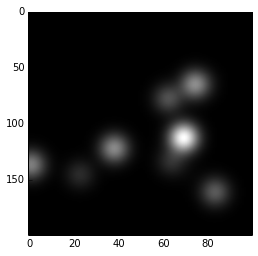

In [41]:
plt.imshow(zz,cmap='gray', aspect=1.*xx.shape[1]/xx.shape[0])

In [42]:
createTestHistograms()